In [ ]:
#AI
#Importamos las librerias necesarias para manipular los datos
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display


In [ ]:
#Instalamos librosa para manipular los audios y obtener los MFCC
!pip install --upgrade librosa

In [ ]:
!pip install numpy scipy soundfile audioread resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.0 MB/s eta 0:00:00


In [ ]:
# Nos conectamos a Drive donde tenemos los Datos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#1 alzheimer
#0 No alzheimer
#Leemos nuestro csv que contiene el path de cada archivo junto a si posee o no alzheimer, tenemos 202 muestras con alzheimer y 202 sin alzheimer
data=pd.read_csv('/content/drive/My Drive/AFDA/Data/alz_data.csv')
data.head()
data['alzheimer'].value_counts()

,count
alzheimer,
1,202
0,202


In [ ]:
audio_dataset_path='/content/drive/My Drive/AFDA/Data'
metadata=pd.read_csv('/content/drive/My Drive/AFDA/Data/alz_data.csv')
metadata.head()

,filepath,alzheimer
0,/content/drive/My Drive/AFDA/Data/alz/DavidMil...,1
1,/content/drive/My Drive/AFDA/Data/noalz/Raquel...,0
2,/content/drive/My Drive/AFDA/Data/noalz/BillWy...,0
3,/content/drive/My Drive/AFDA/Data/noalz/YokoOn...,0
4,/content/drive/My Drive/AFDA/Data/alz/Vampiro_...,1


In [ ]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_best')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features


In [ ]:
# Cargamos el csv
csv_path = '/content/drive/My Drive/AFDA/Data/alz_data.csv'
metadata = pd.read_csv(csv_path)


# Obtenemos las caracteristicas
extracted_features = []

# Extraemos las caracteristicas de cada uno de los archivos de audio junto a su respectivo resultado
for index_num, row in tqdm(metadata.iterrows(), total=metadata.shape[0]):

    file_path = row["filepath"]

    final_class_labels = row["alzheimer"]
    try:
        data = features_extractor(file_path)
        extracted_features.append([data, final_class_labels])
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")


### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

100%|██████████| 404/404 [01:42<00:00,  3.93it/s]


,feature,class
0,"[-414.35803, 132.97815, -9.930243, 13.141352, ...",1
1,"[-155.73123, 73.42242, -23.035572, 16.87636, 1...",0
2,"[-296.90887, 117.5021, -26.029766, 47.02434, -...",0
3,"[-358.20245, 140.43849, -7.0341325, 19.492668,...",0
4,"[-349.1719, 115.767006, -0.6065358, 27.962349,...",1


In [ ]:
### Dividimos los datos para procesarlos
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())
X.shape

(404, 60)

In [ ]:
y[:5]


array([1, 0, 0, 0, 1])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Usamos one hot encoding
y_one_hot = to_categorical(y_encoded)

# Dividimos los datos nuevamente
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.30, random_state=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(np.unique(np.argmax(y_train, axis=1)))
print(np.unique(np.argmax(y_test, axis=1)))

(282, 60) (122, 60)
(282, 2) (122, 2)
[0 1]
[0 1]


In [ ]:

# Observamos la cantidad de datos en cada uno de los sets
train_labels = pd.Series(np.argmax(y_train, axis=1)).value_counts()
test_labels = pd.Series(np.argmax(y_test, axis=1)).value_counts()

print("Training labels distribution:")
print(train_labels)

print("Testing labels distribution:")
print(test_labels)
num_labels = len(np.unique(y))
print(num_labels)

Training labels distribution:
0    150
1    132
Name: count, dtype: int64
Testing labels distribution:
1    70
0    52
Name: count, dtype: int64
2


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D,Conv1D, MaxPooling1D, BatchNormalization, Bidirectional, LSTM, Dense, Dropout, Flatten, Add, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import confusion_matrix


model = Sequential()

#Primera capa convolucional
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

#Segunda capa convolucional
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

#Tercera capa convolucional
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

#Cuarta capa convolucional
model.add(Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

#Capa LSTM
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(num_labels, activation='sigmoid'))
model.summary()

# Métricas
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 58, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 29, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 27, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 11, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 5, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 3, 512)              │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 1, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 1, 100)              │         245,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             202 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 766,490 (2.92 MB)

 Trainable params: 764,570 (2.92 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from datetime import datetime

# funciones de Callback
num_epochs = 200
num_batch_size = 16

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.keras',
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.0001)

# Entrenando el modelo
start = datetime.now()

history = model.fit(
    X_train, y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test),
    callbacks=[checkpointer, early_stopping, reduce_lr],
    verbose=1
)

# Calculando el tiempo de entrenamiento
duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6120 - auc_9: 0.6168 - loss: 1.1924 - precision_9: 0.5630 - recall_9: 0.5799
Epoch 1: val_loss improved from inf to 1.25766, saving model to saved_models/audio_classification.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.6110 - auc_9: 0.6173 - loss: 1.1926 - precision_9: 0.5636 - recall_9: 0.5813 - val_accuracy: 0.5738 - val_auc_9: 0.5999 - val_loss: 1.2577 - val_precision_9: 0.5932 - val_recall_9: 0.5738 - learning_rate: 0.0010
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7783 - auc_9: 0.8231 - loss: 1.0079 - precision_9: 0.7771 - recall_9: 0.6975
Epoch 2: val_loss improved from 1.25766 to 1.20833, saving model to saved_models/audio_classification.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7780 - auc_9: 0.8235 - loss: 1.0075 - precision_9: 0.7768 - recall_9: 0.6972 - val_accuracy: 0.5738 - val_auc_9: 0.6374 - val_loss: 1.2083 - val_precision_9: 0.6000 - val_recall_9:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8093 - auc_9: 0.8753 - loss: 0.9211 - precision_9: 0.7764 - recall_9: 0.8112
Accuracy: 0.8278688788414001, Precision: 0.800000011920929, Recall: 0.8196721076965332, AUC: 0.8904191851615906
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


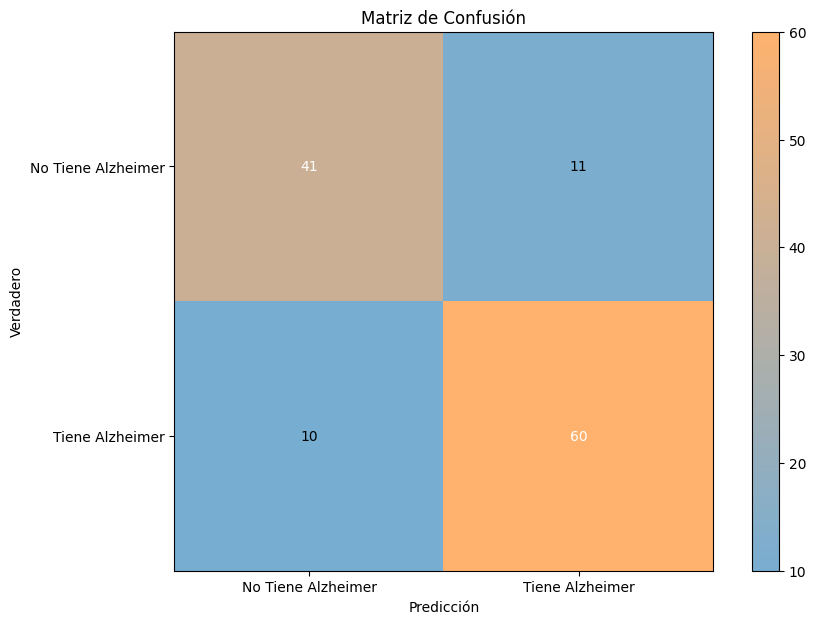

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap

# Evaluate the model
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, AUC: {auc}")

# Predict and create confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

# Create a custom colormap
colors = ["#1f77b4", "#ff7f0e"]  # Azul a rosado salmón
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors)

# Confusion matrix visualization with custom gradient
plt.figure(figsize=(10, 7))
plt.imshow(cm, cmap=cmap, alpha=0.6)  # Use the custom colormap
plt.title('Matriz de Confusión')
plt.colorbar()

# Define class labels
class_labels = ['No Tiene Alzheimer', 'Tiene Alzheimer']  # Replace with actual class names

# Set ticks
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()


In [78]:
y_true = np.argmax(y_test, axis=1)
print(y_true)

[0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0
 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0
 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1
 1 0 0 1 1 1 0 1 0 0 0]


0.8278688788414001
dict_keys(['accuracy', 'auc_9', 'loss', 'precision_9', 'recall_9', 'val_accuracy', 'val_auc_9', 'val_loss', 'val_precision_9', 'val_recall_9', 'learning_rate'])
Training Accuracy:  [0.5921986103057861, 0.7730496525764465, 0.826241135597229, 0.914893627166748, 0.9255319237709045, 0.911347508430481, 0.8971630930900574, 0.914893627166748, 0.957446813583374, 0.9751772880554199, 0.978723406791687, 0.9929078221321106, 0.978723406791687, 0.9609929323196411, 0.9751772880554199, 0.9858155846595764, 0.9716312289237976, 0.9680851101875305, 0.9751772880554199, 0.9964538812637329, 0.978723406791687, 0.9645389914512634, 0.9822695255279541, 0.9751772880554199, 0.9822695255279541, 0.9645389914512634, 0.9645389914512634, 0.9716312289237976, 0.9645389914512634, 0.9858155846595764, 0.978723406791687, 0.9680851101875305, 0.9716312289237976, 0.9609929323196411, 0.978723406791687, 0.9964538812637329, 0.9822695255279541, 0.9822695255279541, 0.9858155846595764, 0.9964538812637329, 1.0, 1.0,

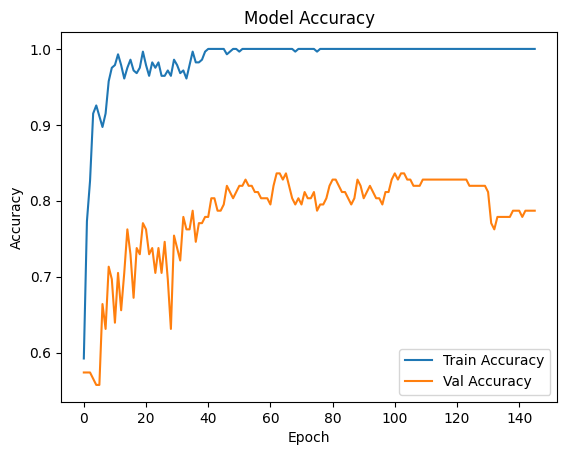

Average Training Accuracy: 0.9862042163332848
Average Validation Accuracy: 0.7803166422941913
Average Training Loss: 0.2884483151137829
Average Validation Loss: 0.9819916307109676


In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

# Accessing metric values
print(history.history.keys())  # Shows available metrics

# For accuracy
print("Training Accuracy: ", history.history['accuracy'])
print("Validation Accuracy: ", history.history['val_accuracy'])


# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

train_acc = history.history['accuracy']  # List of accuracy values per epoch
avg_train_acc = sum(train_acc) / len(train_acc)
print(f'Average Training Accuracy: {avg_train_acc}')

# Calculate average validation accuracy
val_acc = history.history['val_accuracy']
avg_val_acc = sum(val_acc) / len(val_acc)
print(f'Average Validation Accuracy: {avg_val_acc}')

# Calculate average training loss
train_loss = history.history['loss']
avg_train_loss = sum(train_loss) / len(train_loss)
print(f'Average Training Loss: {avg_train_loss}')

# Calculate average validation loss
val_loss = history.history['val_loss']
avg_val_loss = sum(val_loss) / len(val_loss)
print(f'Average Validation Loss: {avg_val_loss}')



In [ ]:
#try an audio

import librosa
import numpy as np
from tensorflow.keras.models import load_model

def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_best')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features


model = load_model('saved_models/audio_classification.keras')

def predict_audio_class(file_path, model):
    # Extract features from the audio file
    features = features_extractor(file_path)

    # Preprocess features to match model input shape
    features = np.expand_dims(features, axis=0)  # Adding batch dimension

    # Make a prediction
    predictions = model.predict(features)

    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)

    # Map the predicted class to class labels (optional)
    class_labels = ['No Tiene alzheimer',' tiene alzheimer']
    return class_labels[predicted_class[0]]

# Example usage
audio_file_path = '/content/drive/MyDrive/AFDA/Data/alz/AbeBurrows_5_segment2.wav'
predicted_class = predict_audio_class(audio_file_path, model)
print(f'Usted: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Usted:  tiene alzheimer
